In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys
sys.executable

'/usr/bin/python3'

# Utils
### - Implement

In [155]:
def get_available_actions(state, grid_reward):
    actions = []
    row, col = state
    grid_size = len(grid_reward)

    if row > 0 and grid_reward[row-1][col] != -100:
        actions.append(ACTION_UP)
    if row < grid_size - 1 and grid_reward[row+1][col] != -100:
        actions.append(ACTION_DOWN)
    if col > 0 and grid_reward[row][col-1] != -100:
        actions.append(ACTION_LEFT)
    if col < grid_size - 1 and grid_reward[row][col+1] != -100:
        actions.append(ACTION_RIGHT)

    return actions

def get_transition(state, action, grid_reward):
    row, col = state
    next_row, next_col = row, col

    if action == 0:
        next_row = row - 1
    elif action == 1:
        next_row = row + 1
    elif action == 2:
        next_col = col - 1
    elif action == 3:
        next_col = col + 1

    if 0 <= next_row < len(grid_reward) and 0 <= next_col < len(grid_reward):
        if grid_reward[next_row][next_col] == -100:
            next_state = state
            #reward = -100
            reward = grid_reward[row][col]
        else:
            next_state = (next_row, next_col)
            reward = grid_reward[next_row][next_col]
    else:
        next_state = state
        reward = grid_reward[row][col]

    return next_state, reward

# Utils
### - Given

In [156]:
def generate_grid_world(obstacles):
    grid_size = 7
    grid_reward = np.full((grid_size, grid_size), -1)

    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)
    grid_reward[end[0], end[1]] = 0

    return grid_reward, start, end

def print_policy(policy):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            else:
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    for row in policy_symbols:
        print(' '.join(row))

def visualize_map(data, title):
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Value')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10")
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            else:
                if israndom:
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
                else:
                    temp_policy_symbol = 0
                    actions = [int(value) for value in str(policy[x, y])]
                    for i, value in enumerate(actions):
                        if i == 0:
                            temp_policy_symbol = ACTION_SYMBOLS.get(value, ' ')
                        else:
                            temp_policy_symbol += ACTION_SYMBOLS.get(value, ' ')
                    policy_symbols[x, y] = temp_policy_symbol

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size+1, 1))
    ax.set_yticks(np.arange(0, grid_size+1, 1))
    ax.set_yticklabels(np.arange(grid_size, -1, -1))
    ax.grid(True)

    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=20)
            else:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=10)
            if grid[x, y] == -100:
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect)
            elif (x, y) == (end[0], end[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3)
                ax.add_patch(rect)
            elif (x, y) == (start[0], start[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect)

    plt.title(title)
    plt.show()

# Policy initialization
### - Implement

In [157]:
def policy_generator(grid_reward, israndom, isall=False):
    grid_size = len(grid_reward)
    policy = np.empty((grid_size, grid_size), dtype=object)

    for row in range(grid_size):
        for col in range(grid_size):
            state = (row, col)
            if not isall and grid_reward[row][col] == 0:
                continue

            available_actions = get_available_actions(state, grid_reward)

            if israndom:
                if available_actions:
                    selected_action = np.random.choice(available_actions)
                else:
                    selected_action = None
            else:
                if available_actions:
                    selected_action = available_actions[0]
                else:
                    selected_action = None

            policy[row, col] = selected_action

    return policy

# Policy evaluation
### - Implement

In [158]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):
    grid_size = grid_reward.shape[0]
    V = np.zeros([grid_size, grid_size])
    iteration = 0

    while True:
        if iteration >= 1000:  #iteration
           break
        delta = 0
        temp = np.copy(V)

        for x in range(grid_size):
            for y in range(grid_size):
                if x == grid_size-1 and y == grid_size-1:
                    continue
                elif grid_reward[x, y] == 100:
                   continue

                old_value = V[x][y]
                current_value = 0

                if israndom:
                    for action in range(4):
                        next_state, reward = get_transition((x, y), action, grid_reward)
                        next_x, next_y = next_state

                        if grid_reward[next_x][next_y] == -100:
                            state_value = reward + discount_factor * (-100)
                        else:
                            state_value = reward + discount_factor * V[next_x][next_y]

                        current_value += 0.25 * state_value
                else:
                    action = policy[x, y]
                    next_state, reward = get_transition((x, y), action, grid_reward)
                    next_x, next_y = next_state

                    if grid_reward[next_x][next_y] == -100:
                        current_value = reward + discount_factor * (-100)
                    else:
                        current_value = reward + discount_factor * V[next_x][next_y]

                temp[x][y] = current_value
                delta = max(delta, abs(old_value - current_value))

        V = np.copy(temp)
        iteration += 1

        # if delta < theta:  #수렴 조건
        #  break

    return V

In [159]:
#policy evaluation 결과 확인
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
policy = policy_generator(grid, israndom=True)
policy_evaluation(grid, policy)

array([[ -9.98009837,  -9.97897893, -99.98157085,  -9.93911374,
         -9.92967565,  -9.90775187,  -9.8818347 ],
       [ -9.97237265,  -9.96851678, -54.95323363,  -9.92149127,
         -9.91090607,  -9.8707461 ,  -9.80339961],
       [ -9.95622399,  -9.94020621,  -9.9021414 ,  -9.87956125,
         -9.88211393,  -9.80348068,  -9.57024009],
       [ -9.9366371 ,  -9.90736767,  -9.84316403,  -9.75897004,
        -54.65027721, -54.29408249,  -8.91283558],
       [ -9.91815835,  -9.86829341,  -9.73447214,  -9.44706042,
         -8.8045925 ,  -8.1462726 ,  -7.77224687],
       [ -9.91317046,  -9.85463923,  -9.66135829,  -9.24445609,
         -8.28915226,  -7.03809958,  -5.26751994],
       [ -9.9281229 ,  -9.91112996, -99.90380986, -99.22454654,
         -7.3090841 ,  -5.13305333,   0.        ]])

# Policy improvement
### -Implement

In [160]:
def policy_improvement(grid_reward, V, discount_factor=0.9):
    grid_size = grid_reward.shape[0]
    new_policy = np.zeros((grid_size, grid_size), dtype=int)

    for x in range(grid_size):
        for y in range(grid_size):
            if grid_reward[x][y] == -100:
                new_policy[x, y] = -1
                continue
            if (x, y) == (6, 6):
                V[(x, y)] = 0
                continue

            actions = get_available_actions((x, y), grid_reward)
            best_action = None
            max_value = float('-inf')

            for action in actions:
                next_state, reward = get_transition((x, y), action, grid_reward)
                action_value = reward + discount_factor * V[next_state]

                if action_value > max_value:
                    max_value = action_value
                    best_action = action

            new_policy[x, y] = best_action

    return new_policy

# Policy iteration
### - Implement

In [161]:
def policy_iteration(max_iterations=100, discount_factor=0.9, theta=1e-1):  ##
    # Initialize a random policy
    policy = policy_generator(grid, israndom=True)
    stable = False
    iteration = 0

    while not stable and iteration < max_iterations:
      V = policy_evaluation(grid, policy, discount_factor=0.9, theta=1e-1)
      new_policy = policy_improvement(grid, V, discount_factor=0.9)
      stable = np.array_equal(policy, new_policy)
      policy = new_policy
      iteration += 1

    V_final = V

    return policy, V_final

# Value iteration
### - Implement

In [162]:
def value_iteration(grid_reward, discount_factor=0.9, theta=1e-1):
    grid_size = grid_reward.shape[0]
    V = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size), dtype=int)
    iteration = 0

    while True:
        if iteration >=1000:  #iteration
          break
        delta = 0
        # Temporary copy of V to hold updates
        V_new = V.copy()
        for x in range(grid_size):
            for y in range(grid_size):
                if x == y and x == grid_size - 1:
                    continue

                max_value = float('-inf')
                for action, (dx, dy) in enumerate([(-1, 0), (1, 0), (0, -1), (0, 1)]):
                    next_x, next_y = x + dx, y + dy
                    if 0 <= next_x < grid_size and 0 <= next_y < grid_size:
                        reward = grid_reward[next_x, next_y]
                        value = reward + discount_factor * V[next_x, next_y]

                        if value > max_value:
                            max_value = value
                            policy[x, y] = action

                V_new[x, y] = max_value
                delta = max(delta, abs(V_new[x, y] - V[x, y]))

        V = V_new
        iteration += 1

        # if delta < theta:  #수렴 조건
        #     break

    return V, policy

# Initialization
### - Given

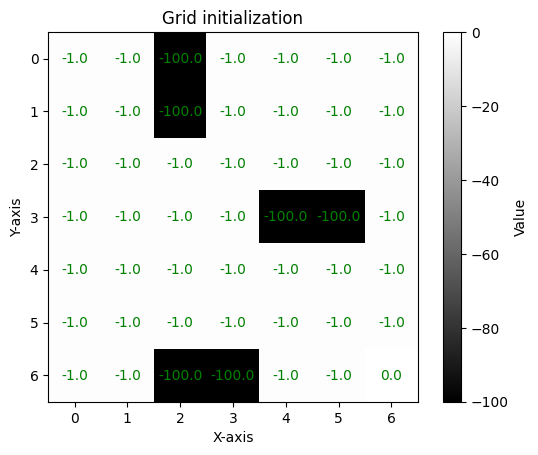

In [163]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

border = f"\n{'='*60}\n"
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
print(border)
visualize_map(grid, "Grid initialization")
print(border)

# Show policy iteration results
### - Given

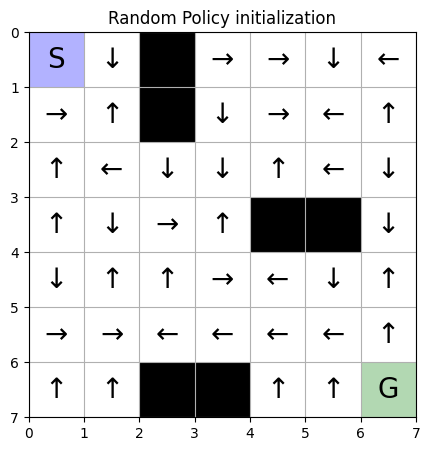

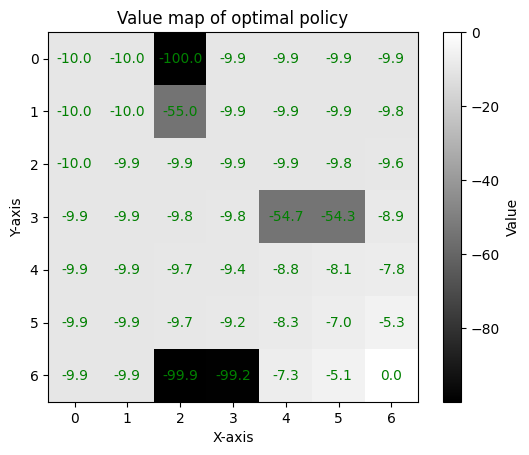

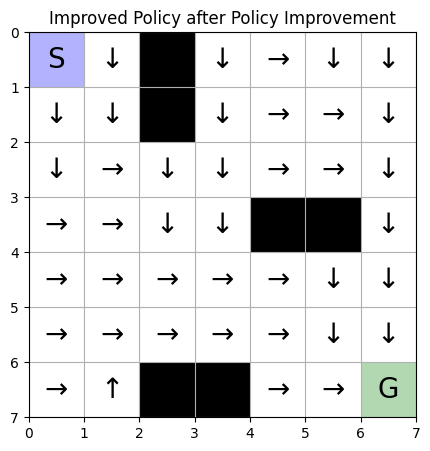

In [164]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True)
visualize_policy(random_policy, start, end, "Random Policy initialization", True)

# Policy iteration
optimal_policy, optimal_value = policy_iteration()
visualize_map(optimal_value, "Value map of optimal policy")
visualize_policy(optimal_policy, start, end, "Improved Policy after Policy Improvement", True)

# Show value iteration results
### - Given

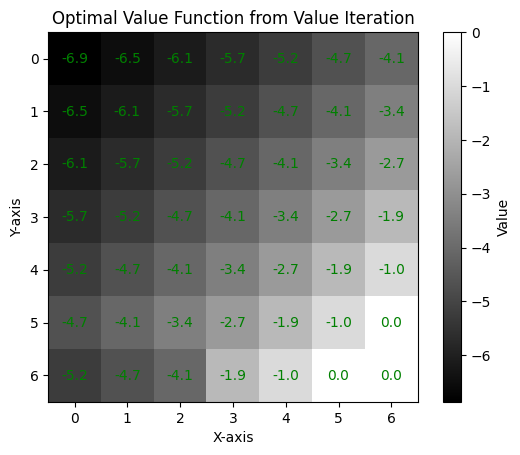

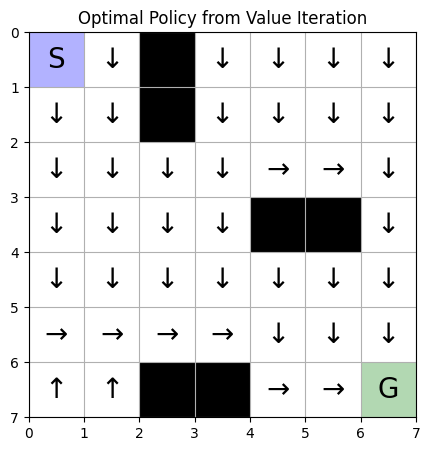

In [165]:
V_opt, optimal_policy = value_iteration(grid)
visualize_map(V_opt, "Optimal Value Function from Value Iteration")
visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True)